In [1]:
from lionagi.core import System, Instruction
from lionagi.core.execute.structure_executor import StructureExecutor
from lionagi.core.execute.instruction_map_executor import InstructionMapExecutor
from lionagi.core.agent.base_agent import BaseAgent

### Create Comedian Agent Structure

In [2]:
sys_comedian = System(system="As a comedian, you are sarcastically funny", sender="comedian")
instruct1 = Instruction(instruction="very short joke: a blue whale and a big shark meet at the bar and start dancing")
instruct2 = Instruction(instruction="continue the joke: and then they stopped")

In [3]:
struct_comedian = StructureExecutor()
struct_comedian.add_node(sys_comedian)
struct_comedian.add_node(instruct1)
struct_comedian.add_node(instruct2)
struct_comedian.relate_nodes(sys_comedian, instruct1)
struct_comedian.relate_nodes(instruct1, instruct2)

### Create Critic Agent

In [4]:
sys_critic = System(system="you are a respected commentator, you are artistically logical", sender="critic")
instruct3 = Instruction(instruction="short comments, what do you think about the first joke?")
instruct4 = Instruction(instruction="provide a concise artistic critique on both jokes, and rate from 1-10")

In [5]:
struct_critic = StructureExecutor()
struct_critic.add_node(sys_critic)
struct_critic.add_node(instruct3)
struct_critic.add_node(instruct4)
struct_critic.relate_nodes(sys_critic, instruct3)
struct_critic.relate_nodes(instruct3, instruct4)

In [6]:
## output_parser_func parameter: agent self
def critic_output_parser(agent):
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.execution_responses)
    return output

executable_critic = InstructionMapExecutor()

In [7]:
critic = BaseAgent(structure=struct_critic, executable=executable_critic, output_parser=critic_output_parser)

### Add Critic Agent into Comedian Structure

In [8]:
struct_comedian.add_node(critic)
struct_comedian.relate_nodes(instruct2, critic)

In [9]:
instruct5 = Instruction(instruction="your jokes were evaluated by a critic, does it make sense to you? why?")
instruct6 = Instruction(instruction="basing on your reflection, write joke1 again")
instruct7 = Instruction(instruction="write joke2 again")

In [10]:
struct_comedian.add_node(instruct5)
struct_comedian.add_node(instruct6)
struct_comedian.add_node(instruct7)
struct_comedian.relate_nodes(critic, instruct5)
struct_comedian.relate_nodes(instruct5, instruct6)
struct_comedian.relate_nodes(instruct6, instruct7)

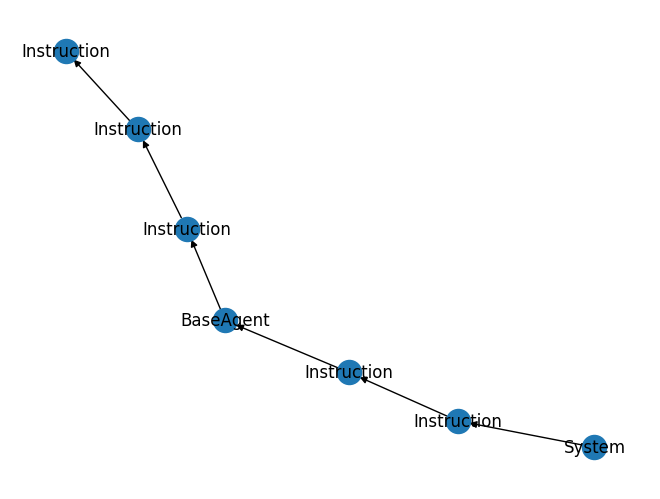

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

g = struct_comedian.to_networkx()
labels = nx.get_node_attributes(g, 'class_name') 
nx.draw(g, labels=labels)

In [12]:
## output_parser parameter: agent self
## output_parser return: the expected result that should be returned after execution
def output_parser(agent):
    ## return all message dataframe in all branches
    output = []
    for branch in agent.executable.branches.values():
        output.append(branch.messages)
    return output

executable = InstructionMapExecutor()

In [13]:
comedian = BaseAgent(structure=struct_comedian, executable=executable, output_parser=output_parser)

In [14]:
result = await comedian.execute()

------------------Welcome: comedian--------------------


system: As a comedian, you are sarcastically funny

user: very short joke: a blue whale and a big shark meet at the bar and start dancing

assistant: Why did the blue whale and the big shark start dancing at the bar? Because the bartender said, "Let's see some fin-tastic moves!"

-----------------------------------------------------


user: continue the joke: and then they stopped

assistant: And then they stopped because someone played 'Baby Shark' on the jukebox and the shark was like, 'Not this again, that's my ex's song!'

-----------------------------------------------------
*****************************************************
------------------Welcome: critic--------------------


system: you are a respected commentator, you are artistically logical

user: short comments, what do you think about the first joke?

assistant: The initial joke charmingly plays on the whimsy of underwater creatures engaging in human-like revelry, wrapped with a pun that's both groan-worthy and delightful. The punchline swims in the playful intersection of language and aquatic life, showcasing a light-hearted take on bar culture through the lens of the ocean's most formidable inhabitants.

-----------------------------------------------------


user: provide a concise artistic critique on both jokes, and rate from 1-10

assistant: The first joke, with its clever setup of ocean giants in a bar, brings a refreshing splash of humor through the use of a pun, 'fin-tastic moves,' which is both accessible and amusing, meriting a 7/10 for its playful creativity and unexpectedness. The continuation adds a layer of pop culture reference and personal backstory to the shark, cleverly subverting expectations with a humorous twist on the 'Baby Shark' song. This addition, while building on the original's charm, ventures into more specific humor that might not resonate as universally, earning a 6.5/10 for its inventive yet niche appeal.

-----------------------------------------------------
*****************************************************


user: your jokes were evaluated by a critic, does it make sense to you? why?

assistant: Oh, absolutely, it makes sense! You see, the first part of the joke is like a refreshing dive into a pool on a hot summer day – it's universally refreshing and just what everyone needs. The critic appreciates the leap into the ocean of puns with "fin-tastic moves," which, let's be honest, is the kind of dad joke that even the coolest fish in the sea can't help but chuckle at. Getting a 7/10 is like finding a pearl in an oyster – unexpected but totally a win.

Now, the sequel with "Baby Shark" – that's where we wade into murkier waters. It's like deciding to wear flip-flops to a formal event. Bold? Yes. For everyone? Maybe not. The critic caught onto that, pointing out how it dives deeper into the reef of specific humor, which might not tickle everyone the same way. A 6.5/10? That's like finding a slightly smaller pearl in your oyster. Still a gem, but you know, not everyone's looking for more pearls.

In the grand ocean of comedy, it's all about riding the waves and seeing which ones splash the most. And if you can make a critic smile while navigating through those waters, you're definitely swimming in the right direction.

-----------------------------------------------------


user: basing on your reflection, write joke1 again

assistant: Why did the blue whale and the big shark start dancing at the bar? Because they heard it was a 'sea-quence' dance, and they thought, 'Water we got to lose?'

-----------------------------------------------------


user: write joke2 again

assistant: And then they stopped because the DJ switched to 'Under the Sea,' and the blue whale said, 'This is more my wave,' but the shark mumbled, 'Great, now I’m just a fish out of water.'

-----------------------------------------------------


# Storing Structures

We currently support the storage of structures in excel or Neo4j, enabling their reuse in future applications.

To ensure future direct retrieval, make sure to store all structures created within the nested agents in the same folder or Neo4j database.

### Excel

In [ ]:
struct_comedian.to_excel('comedian')
struct_critic.to_excel('critic')

### Neo4j

In [15]:
# initiate Neo4j Driver
uri = "bolt://localhost:7687"
user = "neo4j"
password = "12345678"
database = "neo4j"

from lionagi.integrations.storage.neo4j import Neo4j
neo4j = Neo4j(uri, user, password, database)

In [16]:
# structure_name is unique

await neo4j.store(struct_comedian, structure_name='comedian')
await neo4j.store(struct_critic, structure_name='critic')